In [1]:
# Import libraries 
import os
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch 

import pickle 
import matplotlib.pyplot as plt

import numpy as np

import cv2

import  time
import glob
from scipy.io import loadmat
import random
from random import seed, randint

from sklearn.model_selection import train_test_split

import pandas as pd

from imutils.video import FPS

import imutils

from torch.utils.data import DataLoader, Dataset

from threading import Thread
import sys

from queue import Queue

from imutils.video import FileVideoStream

import numpy as np
import argparse
import imutils
import time
import pytorchvideo 
import torch.nn as nn

In [3]:
#%% Prepare Data Loader ???

import importlib
import torch.nn as nn

#%% 
import losses_PT
importlib.reload(losses_PT)

#optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-4)

from losses_PT import TripletLoss1, InfoNceLoss, NT_Xent, InfoNCE, align_uniform
L= InfoNceLoss(0.5)

tan_m =  nn.Tanh()


# model_name = "slowfast_r50"
# model = torch.hub.load("facebookresearch/pytorchvideo", model=model_name, pretrained=False)

In [4]:
def set_deterministic(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

set_deterministic(seed=42)

In [5]:
#%% Data Directory

def get_files(path_dir = '../Data/Pickle_files'):
    dataPath = os.path.join(path_dir, '*.pkl')
    return glob.glob(dataPath)  # care about the serialization


files = get_files(path_dir = '../Data/Pickle_files')

LabelDict= {'sitting':0, 'standing':1, 'lying_d':2, 'lying_u':3, 'walking':4, 'push_up':5, 'object_walk':6, 'object_pick':7, 'hand_wave':8, 'leg_exer':9, 'what':10}


def get_key(my_dict, val):
    for key, value in my_dict.items():
         if val == value:
             return key
    return "key doesn't exist"

def verify_supset(pos, idx, s1 , fr = 1 ):
    print(get_key(LabelDict, idx[pos]))
    plt.imshow(np.moveaxis((s1[0][pos,:,fr,:,:]).cpu().numpy(), 0,2), vmin=0., vmax=1.)
    plt.show()
    return
# verify_supset(1, idx[0], s1, fr = 15)
# after s1, idx =SuPSET dataloader

In [6]:
#%% Only when required to change the data-source
# files[0:8], files[16:24] = files[16:24], files[0:8]
files.sort()
files[18]

'../Data/Pickle_files/emon_13_12_2021_ind_300_300.pkl'

In [7]:
#%% Creating a Big Dictionary with Labels 
with open('label_info.pkl', 'rb') as f:
    label_info = pickle.load(f)

In [8]:
#%% Dataset Loader (final format)
import pickle
import data_set_loader
import importlib
importlib.reload(data_set_loader)
from data_set_loader import data_set_Prep
from data_set_loader import brightness_augment, snp_RGB, test_data



def dataSetLoader(files, mode_no = 'InfoNCE', samp_siz =8 , S = set([0,1,2]), l_info = (None, None), frm_no = 16, SS = None):
    temp, dataSet, concat_dataset, data_loader = [], [], [], []
    import pdb
    for i in range(len(files)):
        with open(files[i], 'rb') as f:
            temp.append(pickle.load(f))
            
        dataSet.append(data_set_Prep(temp[i], frm_no = frm_no, mode_no = mode_no, samp_siz= samp_siz, S = S,
                                     l_info=(l_info[files[i]]['gt_id'], l_info[files[i]]['gt_name']), SS = SS))
            
    concat_dataset = torch.utils.data.ConcatDataset(dataSet)
    data_loader = DataLoader(concat_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
    return data_loader


# for i in range(1):
#     data_loader = []
#     del(data_loader)
#     torch.cuda.empty_cache()

#     # mode_no = 'InfoNCE', 'Triplet', 'SimCLR', 'AlUn', SupSet, AdvNCE, TCLR, NCDSUP, Neg_learn
#     mode_no = 'Neg_learn'
#     data_loader = dataSetLoader(files[10:11], mode_no =  mode_no, samp_siz = 8, S = set([0,1,2]), l_info = label_info, 
#                                frm_no = 16, SS =[0,1,2,3,4,5,6])

In [9]:
# temp[1][2].dtype
# resizing videos 
from torchvision import transforms
from torchvision.transforms import (
    RandomCrop,
    RandomResizedCrop,
)

class ReSizeVid():
    def __init__(self, size = (256, 256)):
        self.size = size
    
    def __call__(self, t_v):
        ll =  t_v.shape
        kk = torch.empty((ll[0], ll[1], ll[2], ll[3], self.size[0], self.size[1]))
        for i in range(ll[1]):
            kk[:, i,:,:,:,:] =  self.resize(t_v[0,i], self.size)
        return kk
    
    def resize(self, clip, target_size, interpolation_mode =  "bilinear"):
        assert len(target_size) == 2, "target size should be tuple (height, width)"
        return torch.nn.functional.interpolate(
            clip, size=target_size, mode=interpolation_mode
        )

# trx = transforms.Compose([ReSizeVid((224, 224))]) # r2+1 d 
# trx = transforms.Compose([ReSizeVid((160,160))]) #p3D model
# trx = transforms.Compose([ReSizeVid((112, 112))]) # r3D model
# trx = transforms.Compose([ReSizeVid((224, 224))]) # r3D model

In [10]:
#%% loading pretrain weight for the P3D199  

def load_wt(net, pretrained_file='p3d_rgb_199.checkpoint.pth.tar'):
    weights=torch.load(pretrained_file)
    net.load_state_dict(weights)

In [11]:
from p3D_net import P3D131, P3D199, P3D63
from R3D_model import R3DClassifier
import r2plus1d_ptv
from r2plus1d_ptv import create_r2plus1d
from torchsummary import summary
import pytorchvideo.models as models
import torch.nn as nn
from pytorchvideo.models import create_slowfast
import torch.nn as nn
#%% Input Model name
def get_model(pt = 0, ModName = None):
    def str_to_class(ModelName):
        return getattr(sys.modules[__name__], ModelName) 
    if ModName == None:
        ModName = input("Input your model name C3D, P3D199, P3D63, P3D131 \n")
        ModelName = str_to_class(ModName)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    if ModName == 'C3D':
        net = ModelName()
        net.load_state_dict(torch.load('../../Saved_models/c3d.pickle'))
        net = net.cuda()
        input_shape = (3,16,112,112)
        print(summary(net, input_shape))
    elif ModName == 'P3D199':
        net = ModelName(False, 'RGB',num_classes=400)
        net = net.cuda()
        input_shape = (3,16,160,160)
        print(summary(net, input_shape))
    elif ModName == 'P3D63' or ModName == 'P3D131':
        net = ModelName(num_classes=400)
#         net.to(device)
#         input_shape = (3,16,160,160)
#         print(summary(net, input_shape))
    elif ModName =='R2+1D':
        net = create_r2plus1d()
        if pt ==1:
            wt = torch.load('R2PLUS1D_16x4_R50.pyth')
            net.load_state_dict(wt["model_state"])
    elif ModName == 'R3D':
        if pt ==1:
            net = R3DClassifier(101, (2, 2, 2, 2), pretrained=True)
        if pt ==0:
            net = R3DClassifier(num_classes, (2, 2, 2, 2), pretrained=True)
    return net 
    #more network here!!
    #SLOWFAST
class L2Norm(nn.Module):
    def forward(self, x):
        return x / x.norm(p=2, dim=1, keepdim=True)

In [12]:
import torch.nn as nn
def get_R_model(num_classes = 100, mlp = 0, ModName = None, pt = 0): # single layer only can add many layers if wanted
    if ModName == None:
        net = get_model()
        mod_frm_no = 16
        trx = transforms.Compose([ReSizeVid((160, 160))]) # p3d # forced layer removal
        dim_layer = 2048
        net.fc = nn.Linear(in_features=dim_layer, out_features= dim_layer)
        if mlp == 0: 
            my_net = torch.nn.Sequential(net, nn.ReLU(), nn.Linear(dim_layer, num_classes), L2Norm())
        else:
            net.fc = nn.Linear(in_features=2048, out_features= num_classes, bias = True)
            my_net = nn.Sequential(net, nn.ReLU())
    if ModName == 'R2+1D':
        mod_frm_no = 16
        my_net = get_model(pt = pt, ModName = ModName)
        trx = transforms.Compose([ReSizeVid((224, 224))]) # r2+1 d 
        if mlp:
            my_net.blocks[5] = nn.Sequential(*list(my_net.blocks[5].children())[:-3], nn.Flatten(),
                                          nn.Linear(in_features=2048, out_features=num_classes, bias=True), nn.ReLU()
                                         )
        else:
            my_net.blocks[5] = nn.Sequential(*list(my_net.blocks[5].children())[:-3], nn.Flatten(), 
                                          nn.Linear(in_features=2048, out_features=2048, bias=True), nn.ReLU(),
                                          nn.Linear(in_features=2048, out_features=num_classes, bias=True), nn.ReLU()
                                         )
    if ModName == 'R3D':
        net = get_model(pt = pt, ModName = ModName)
        mod_frm_no = 16
        trx = transforms.Compose([ReSizeVid((112, 112))]) # r3d 
        if mlp == 0:
            net.linear = torch.nn.Linear(in_features=512, out_features=num_classes)
            my_net = torch.nn.Sequential(net, torch.nn.ReLU())
        else:
            net.linear = torch.nn.Linear(in_features=512, out_features=512)
            my_net = torch.nn.Sequential(net, torch.nn.ReLU(),
                                        nn.Linear(in_features=512, out_features=num_classes), nn.ReLU())
    
    if ModName == 'slowfast':
        my_net = create_slowfast(model_depth=50)
        mod_frm_no = 64
        trx = transforms.Compose([ReSizeVid((224, 224))]) # slowfast 
        if pt ==1:
            wt = torch.load('../SLOWFAST_8x8_R50.pyth')
            my_net.load_state_dict(wt["model_state"])
        if mlp ==0:
            my_net.blocks[6] = nn.Sequential(*list(my_net.blocks[6].children())[:-2], nn.AdaptiveAvgPool3d(1), 
                                       nn.Flatten(),
                                    nn.Linear(in_features=2304, out_features=1000, bias=True), nn.ReLU()
                                  )
        else:
            my_net.blocks[6] = nn.Sequential(*list(my_net.blocks[6].children())[:-2], nn.AdaptiveAvgPool3d(1), 
                                       nn.Flatten(),
                                    nn.Linear(in_features=2304, out_features=2304, bias=True), nn.ReLU(), 
                                    nn.Linear(in_features=2304, out_features=1000, bias=True), nn.ReLU()
                                  )
    
    return my_net, trx, mod_frm_no

# del my_net
# torch.cuda.empty_cache()
# ModName = 'slowfast'

ModName = 'R2+1D'

# ModName = 'R3D'
    
my_net, trx, mod_frm_no = get_R_model(1000, mlp = 0, ModName = ModName, pt = 1)
# my_net.cuda()

cuda:0


In [13]:
#%% Further Model modification

class TLNet(nn.Module):
    def __init__(self, net_name = None, pretrain=True, input_=1024):
        super(TLNet, self).__init__()

        self.net = net_name
        self.net.blocks[5] =  nn.Sequential(*list(self.net.blocks[5].children())[:-4])
        self.head_rep = nn.Linear(in_features=2048, out_features=512, bias=True)
        self.head_rep_ac = nn.ReLU()
        self.head_cls = nn.Linear(in_features=512, out_features=10, bias=True)
        self.head_cls_ac = nn.Softmax()
        
    def forward(self, x: torch.Tensor):
        x1 = self.net(x)
        y1 = self.head_rep_ac(self.head_rep(x1))
        
        y2 = self.head_cls(y1)
        return y1, y2

In [14]:
my_net = TLNet(my_net.cpu())

In [15]:
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)
from torchvision.transforms import Compose, Lambda
class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors.
    """
    def __init__(self, alpha = 4):
        super().__init__()
        self.alpha = alpha

    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // self.alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

vdat= torch.rand(5, 3, 64, 224, 224)

def sf_data_ready(vdat, num_frame = 32):
    
    num_frames = num_frame
    
    transform1=Compose(
        [
            UniformTemporalSubsample(num_frames),
            PackPathway()
        ]
    )
    device = 'cuda'
    
    s2 =[[], []]
    for i in range(vdat.shape[0]):
        f = transform1(vdat[i])
        f = [_.to(device)[None, ...] for _ in f]
        s2[0].append(f[0])
        s2[1].append(f[1])
    
    for i in range(2):s2[i] = torch.cat((s2[i][0:]))

    return s2

In [17]:
def del_net(): ## Delete network 
    del(my_net)
    torch.cuda.empty_cache()
    return

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
#             nn.Linear(1000, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 3)
        )

    def forward(self, img):
        cam_lab = self.model(img)
        return cam_lab

discriminator = Discriminator().cuda()

In [19]:
sm = nn.Softmax(dim= 1)
import pdb
def neg_loss(ip, SS):
    yn = sm(ip)
    nl = torch.zeros(1,10, dtype= torch.float32)
    nl[0][SS] = torch.tensor(1.0)
    return torch.sum(-torch.mm(nl.cuda(),torch.log(1.0 - yn+1*10**-8).t()))


def entropy_loss(ip, SS):
    st = np.arange(0, 10, 1)
    sd = np.setdiff1d(st, SS)
    yn = sm(ip[:, sd]).cuda()
    return -torch.mean(torch.sum(yn*torch.log(yn), axis = 1))
    
    

In [20]:
def var_loss(ip, SS):
    st = np.arange(0, 10, 1)
    sd = np.setdiff1d(st, SS)

    yn = sm(ip[:, sd]/0.005).cuda()
    obj_var = (yn.shape[1] -1)/yn.shape[1]**2
    var_v= yn.var(0)
    
    return torch.mean(torch.relu(obj_var - var_v))
#     return torch.sum(torch.square(var_v - obj_var)

In [35]:
#%% SupCon Setting
#%% InfoNCE Alternate training loop from dataloader

my_net.cuda()

L= InfoNCE(temperature=0.1)
SupL =  nn.CrossEntropyLoss().cuda()
import pdb

def AdvNCD_SUP_train(criterion, my_net, discriminator,  data_loader, lr= 1e-3, bs  =1, disc_tr = 0, SS = None):
    j = 0
    scaler = torch.cuda.amp.GradScaler()
    optimizer = torch.optim.SGD(my_net.parameters(), lr= lr) # very relevant params
    d_optim = torch.optim.SGD(discriminator.parameters(), lr = 1.0e-3)
    optimizer.zero_grad()
    d_optim.zero_grad()
    L = criterion.cuda()
    my_net.train()
    for s1, s2, s3 in data_loader: 
        s1 =  trx(s1)
        s2 =  s2[0].cuda()
        s3 =  s3[0].cuda()
        ad_targ = torch.zeros(s2.size())
        ad_targ = ad_targ.type(torch.LongTensor).cuda()
        
        if ModName == 'slowfast':
            s1 = sf_data_ready(s1[0])
        else:                
            s1 =  s1[0].cuda()
        
        if disc_tr ==0:
            with torch.cuda.amp.autocast():
                output, o2 = my_net(s1)
                loss2 = SupL(discriminator(output), ad_targ)
                
                if s3[0] > 100:
                    if s3[0] == 1000:
                        loss1 = L(output[0:1], output[1:2], output[2:])
                        loss3 = neg_loss(o2[0:2], SS)
                        
                    else:
                        loss3 = neg_loss(o2, SS)
                        e_l = entropy_loss(o2, SS) 
                        v_l = var_loss(o2, SS)
                        loss1 = e_l + v_l
                        if j%500==0:
                            print('entropy loss', e_l.cpu()*bs, 'variance loss', v_l.cpu()*bs)
                        
                else:
                    loss1 = L(output[0:1], output[1:2], output[2:])
                    loss3 = SupL(o2[0:2],s3)
                loss_s = (loss1 + 0.00001*loss2 + loss3)/bs    
                discriminator.zero_grad()
            scaler.scale(loss_s).backward()
            if ((j+1)%bs == 0) or (j+1 ==len(data_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()   # zero the gradient buffers
        else:
            with torch.no_grad(): output = my_net(s1)
        
        
        if (j%1000==0)|disc_tr:
            d_optim.zero_grad()
            output = output.to(torch.float32).detach()
            cam_guess = discriminator(output)
            d_loss = SupL(cam_guess, s2)
            d_loss.backward()
            d_optim.step()

#         pdb.set_trace()
        
        if j%500==0:
            if disc_tr ==0:
                print('cl', loss1.cpu()*bs, 'adv_nce', loss2.cpu()*bs, 'sup_loss', loss3.cpu()*bs)
            print(d_loss.cpu())
            print(s3[0].cpu())
            
        j= j+1
        if j == 3000:
            break
        
        
def AdvInfo_train_NCD(my_net, discriminator):
    for i in [0,1,2,3,0,1,2,3]:
        data_loader = []; del(data_loader); torch.cuda.empty_cache()
#         data_loader = dataSetLoader(files[i+1:25:4], mode_no = 'AdvNCE', samp_siz = 12, S = set([0,1,2]), frm_no= mod_frm_no)
        SS =  [0,1,2,3,6,8,9]
        data_loader = dataSetLoader(files[i+1:25:4], mode_no = 'Neg_learn', samp_siz = 10,l_info = label_info, S = set([0,1,2]), frm_no= mod_frm_no, SS = SS)
        AdvNCD_SUP_train(L, my_net, discriminator, data_loader, lr = 0.5e-3, bs =1, SS = SS)
        del(data_loader)
        torch.cuda.empty_cache()
        
AdvInfo_train_NCD(my_net, discriminator) ### what are you running TCLR or INFONCE TCN

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3732: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


cl tensor(1.1528, grad_fn=<MulBackward0>) adv_nce tensor(1.1717, grad_fn=<MulBackward0>) sup_loss tensor(1.3762, grad_fn=<MulBackward0>)
tensor(1.1343, grad_fn=<ToCopyBackward0>)
tensor(9)
entropy loss tensor(0.0755, grad_fn=<MulBackward0>) variance loss tensor(0.0741, grad_fn=<MulBackward0>)
cl tensor(0.1496, grad_fn=<MulBackward0>) adv_nce tensor(1.3110, grad_fn=<MulBackward0>) sup_loss tensor(0.0060, grad_fn=<MulBackward0>)
tensor(1.1343, grad_fn=<ToCopyBackward0>)
tensor(10000)
cl tensor(0.3048, grad_fn=<MulBackward0>) adv_nce tensor(1.1709, grad_fn=<MulBackward0>) sup_loss tensor(0.1283, grad_fn=<MulBackward0>)
tensor(1.1170, grad_fn=<ToCopyBackward0>)
tensor(3)
cl tensor(0.0075, grad_fn=<MulBackward0>) adv_nce tensor(1.1777, grad_fn=<MulBackward0>) sup_loss tensor(0.0244, grad_fn=<MulBackward0>)
tensor(1.1170, grad_fn=<ToCopyBackward0>)
tensor(8)
cl tensor(0.0045, grad_fn=<MulBackward0>) adv_nce tensor(1.1425, grad_fn=<MulBackward0>) sup_loss tensor(0.1836, grad_fn=<MulBackward0>

In [24]:
#%% UNO baseline recreation

my_net.cuda()

import sink_knopp
from sink_knopp import  SinkhornKnopp

L= InfoNCE(temperature=0.1)
SupL =  nn.CrossEntropyLoss().cuda()
sk = SinkhornKnopp()
import pdb

def UNO_SH_train(criterion, my_net, discriminator,  data_loader, lr= 1e-3, bs  =1, disc_tr = 0, SS = None):
    j = 0
    st = np.arange(0, 10, 1)
    sd = np.setdiff1d(st, SS)

    
    scaler = torch.cuda.amp.GradScaler()
    optimizer = torch.optim.SGD(my_net.parameters(), lr= lr) # very relevant params
    d_optim = torch.optim.SGD(discriminator.parameters(), lr = 1.0e-3)
    optimizer.zero_grad()
    d_optim.zero_grad()
    L = criterion.cuda()
    my_net.train()
    for s1, s2, s3 in data_loader: 
        s1 =  trx(s1)
        s2 =  s2[0].cuda()
        s3 =  s3[0].cuda()
        ad_targ = torch.zeros(s2.size())
        ad_targ = ad_targ.type(torch.LongTensor).cuda()
        
        if ModName == 'slowfast':
            s1 = sf_data_ready(s1[0])
        else:                
            s1 =  s1[0].cuda()
        
        if disc_tr ==0:
            with torch.cuda.amp.autocast():
                output, o2 = my_net(s1)
                loss2 = SupL(discriminator(output), ad_targ)
                
                if s3[0] > 100:
                    if s3[0] == 1000:
                        
                        loss1 = L(output[0:1], output[1:2], output[2:])
                    
                        
                    else:
                        yn = o2[:, sd].cuda()
                        p_target = sk(yn)
                        
                        loss1 = SupL(yn + 1*10**-8, sm(p_target/0.1))
                        if j%500==0:
                            print('sk_retraining loss',loss1.cpu()*bs)
                        
                else:
                    loss_ = L(output[0:1], output[1:2], output[2:])
                    loss3 = SupL(o2[0:2],s3)
                    loss1 = loss_+loss3
                    
                loss_s = (loss1 + 0.00001*loss2)/bs    
                discriminator.zero_grad()
            scaler.scale(loss_s).backward()
            if ((j+1)%bs == 0) or (j+1 ==len(data_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()   # zero the gradient buffers
        else:
            with torch.no_grad(): output = my_net(s1)
        
        
        if (j%1000==0)|disc_tr:
            d_optim.zero_grad()
            output = output.to(torch.float32).detach()
            cam_guess = discriminator(output)
            d_loss = SupL(cam_guess, s2)
            d_loss.backward()
            d_optim.step()

#         pdb.set_trace()
        
        if j%500==0:
            if disc_tr ==0:
                print('cl', loss1.cpu()*bs, 'adv_nce', loss2.cpu()*bs, 'sup_loss')
            print(d_loss.cpu())
            print(s3[0].cpu())
            
        j= j+1
        if j == 3000:
            break
        
        
def UNO_train_NCD(my_net, discriminator):
    for i in [0,1,2,3,0,1,2,3]:
        data_loader = []; del(data_loader); torch.cuda.empty_cache()
#         data_loader = dataSetLoader(files[i+1:25:4], mode_no = 'AdvNCE', samp_siz = 12, S = set([0,1,2]), frm_no= mod_frm_no)
        SS =  [0,1,2,3,6,8,9]
        data_loader = dataSetLoader(files[i+1:24:4], mode_no = 'Neg_learn', samp_siz = 10,l_info = label_info, S = set([0,1,2]), frm_no= mod_frm_no, SS = SS)
        UNO_SH_train(L, my_net, discriminator, data_loader, lr = 0.5e-3, bs =1, SS = SS)
        del(data_loader)
        torch.cuda.empty_cache()
        
UNO_train_NCD(my_net, discriminator) ### what are you running TCLR or INFONCE TCN

sk_retraining loss tensor(0.4443, grad_fn=<MulBackward0>)
cl tensor(0.4443, grad_fn=<MulBackward0>) adv_nce tensor(1.1672, grad_fn=<MulBackward0>) sup_loss
tensor(1.0751, grad_fn=<ToCopyBackward0>)
tensor(10000)
cl tensor(0.5050, grad_fn=<MulBackward0>) adv_nce tensor(1.1853, grad_fn=<MulBackward0>) sup_loss
tensor(1.0751, grad_fn=<ToCopyBackward0>)
tensor(9)
cl tensor(0.0497, grad_fn=<MulBackward0>) adv_nce tensor(1.1951, grad_fn=<MulBackward0>) sup_loss
tensor(1.1141, grad_fn=<ToCopyBackward0>)
tensor(1000)
cl tensor(0.1060, grad_fn=<MulBackward0>) adv_nce tensor(1.1982, grad_fn=<MulBackward0>) sup_loss
tensor(1.1141, grad_fn=<ToCopyBackward0>)
tensor(8)
cl tensor(0.0370, grad_fn=<MulBackward0>) adv_nce tensor(1.2268, grad_fn=<MulBackward0>) sup_loss
tensor(1.1664, grad_fn=<ToCopyBackward0>)
tensor(1000)
cl tensor(0.3293, grad_fn=<MulBackward0>) adv_nce tensor(1.2253, grad_fn=<MulBackward0>) sup_loss
tensor(1.1664, grad_fn=<ToCopyBackward0>)
tensor(1000)
cl tensor(0.0739, grad_fn=<Mu

KeyboardInterrupt: 

In [44]:
#%% Preparing test dataset (change for every new dataset)
# test result
# a = np.int16([0, 1650 , 3240, 4530, 6240,7980,9180,10980, 11580,12030])

my_net = my_net.cuda()
import pdb
def embed_test(files, my_net):
    data_t =[] 
    data_lab = []
    my_net.eval()
    for files_name in files:
        td, aaa, named_labe = tstDataLoad(files_name)
#         pdb.set_trace()
        for i in range(aaa.shape[0]-2):
            for _ in range(100):
                sample = torch.from_numpy(td.get_data_test(randint(aaa[i], aaa[i+1])))
                sample = trx(sample[None, :])[0]
                if ModName == 'slowfast': 
                    sample = sf_data_ready(sample)
                else:
                    sample = sample.cuda()
                with torch.no_grad():
                    _, output = my_net(sample)
                data_t.append(output.cpu().numpy())
                data_lab.append([ i, i, i])
    data_t = np.array(data_t)
    data_lab = np.int16(data_lab)
    h,w,l = data_t.shape
    data_t = data_t.reshape((h*w,l))
    data_lab = data_lab.reshape((h*w,1))
    return data_t, data_lab, h, w, named_labe

def tstDataLoad(files):
    temp = []
    with open(files, 'rb') as f:
            temp.append(pickle.load(f))
    td = test_data(temp[0], frm_no= mod_frm_no)
    aaa = label_info[files]['gt_id']
    named_labe =  label_info[files]['gt_name']
    return td, aaa, named_labe
    

my_net.cuda()

data_t, data_lab, h, w, named_labe = embed_test(files[12:15], my_net)
# rmsev=  data_t/np.sqrt(np.sum(data_t**2, axis = 1))[:, np.newaxis] # 

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3732: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8100 samples in 0.008s...
[t-SNE] Computed neighbors for 8100 samples in 0.230s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8100
[t-SNE] Computed conditional probabilities for sample 2000 / 8100
[t-SNE] Computed conditional probabilities for sample 3000 / 8100
[t-SNE] Computed conditional probabilities for sample 4000 / 8100
[t-SNE] Computed conditional probabilities for sample 5000 / 8100
[t-SNE] Computed conditional probabilities for sample 6000 / 8100
[t-SNE] Computed conditional probabilities for sample 7000 / 8100
[t-SNE] Computed conditional probabilities for sample 8000 / 8100
[t-SNE] Computed conditional probabilities for sample 8100 / 8100
[t-SNE] Mean sigma: 0.420448
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.279320
[t-SNE] KL divergence after 1000 iterations: 0.845740


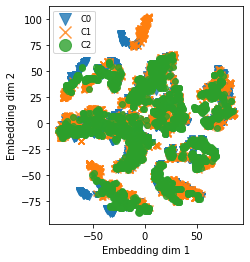

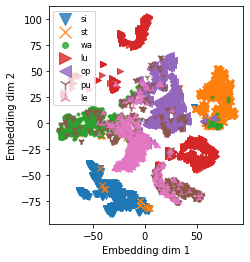

In [45]:
from sklearn.manifold import TSNE
import seaborn as sns
label3 = np.reshape(np.int16([ i for i in range(h*w)])%3, (h*w,1))
View_po = ['C0', 'C1', 'C2']

# if 'X_embedded' in locals():
#     None
# else:
#     X_embedded = TSNE(n_components=2, verbose=1).fit_transform(data_t)
 

def tsne_plot(data = data_t, n_comp = 3, label1 = label3, Lol = None, LoL = 1):
    if Lol== None:
        X_embedded = TSNE(n_components=n_comp, verbose=1).fit_transform(data)
    else:
        X_embedded = LoL
            
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    if n_comp == 3:ax = fig.add_subplot(projection ='3d')
    
    # cdict = {0: 'red', 1: 'blue', 2: 'green'}
    
    markers = ['v', 'x', 'o', '.', '>', '<', '1', '2', '3']
    
    for i, g in enumerate(np.unique(label1)):
        ix = np.where(label1 == g)
        if n_comp==3:
            ax.scatter(X_embedded[ix,0], X_embedded[ix,1], X_embedded[ix,2], marker = markers[i], label = g, alpha = 0.8)
        else:
            ax.scatter(X_embedded[ix,0], X_embedded[ix,1], marker = markers[i], label = View_po[g], alpha = 0.8)
    
    ax.set_xlabel('Embedding dim 1')
    ax.set_ylabel('Embedding dim 2')
    if n_comp==3:ax.set_zlabel('Z Label')
    if n_comp==3:ax.set_zlabel('Z Label')
    ax.legend(fontsize='small', markerscale=2, loc = "upper left", ncol = 1)
    fig.savefig("camera_info_sf_adv.svg", dpi=500, format='svg', metadata=None)
    plt.show()
    #plt 2
    fig = plt.figure()
    ax = fig.add_subplot()
    if n_comp == 3:ax = fig.add_subplot(projection ='3d')
    
    col_map = [ 'Blues',  'BrBG','cool', 'BrBG_r', 'BuGn','Spectral',  'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 
               'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 
               ]
    # cdict = {0: 'red', 1: 'blue', 2: 'green'}
    markers = ['v', 'x', '.', '>', '<', '1', '2', '3', '4', ]
    label_g =  {"sitting": "si",
                "standing": "st",
                "walking": "wa",
                "lying_d": "ld",
                "lying_u": "lu",
                "object_walk": "ow",
                "object_pick": "op",
                "push_up": "pu",
                "leg_exer": "le",
                "hand_wave": "hw"
               }
    
    for i, g in enumerate([0,1,2,4,6,7,8]):# enumerate(np.unique(data_lab)):,,  
        ix = np.where(data_lab == g)[0]
        if n_comp==3:
            ax.scatter(X_embedded[ix,0], X_embedded[ix,1], X_embedded[ix,2], marker = markers[i], label = g, alpha = 0.8)
        else:
            ax.scatter(X_embedded[ix,0], X_embedded[ix,1], marker = markers[i], label = label_g[named_labe[g]], alpha = 0.8)
#             ax.scatter(X_embedded[ix,0], X_embedded[ix,1], marker = markers[i], label = g, alpha = 0.8)
#             ax.scatter(X_embedded[ix,0], X_embedded[ix,1], marker = markers[i], label = 'A'+str(g), alpha = 0.8)
#             g = sns.kdeplot(X_embedded[ix,0], X_embedded[ix,1], cmap=col_map[i], fill=False, thresh=0.03,label = named_labe[g], ax=ax)
    
    ax.set_xlabel('Embedding dim 1')
    ax.set_ylabel('Embedding dim 2')
    ax.legend(fontsize='small', markerscale=2, loc = "upper left", ncol = 1)
#     ax.legend()
    ax.set_aspect('equal', adjustable='box')
    fig.savefig("Act_lab_sf_adv.svg", dpi=500, format='svg', metadata=None)

    plt.show()
    #plt 3
#     fig = plt.figure()
#     ax = fig.add_subplot()
#     if n_comp == 3:ax = fig.add_subplot(projection ='3d')
    
#     # cdict = {0: 'red', 1: 'blue', 2: 'green'}
#     markers = ['v', 'x', '.', '>', '<', '1', '2', '3', '0']
#     for i, g in enumerate([0,4]):# enumerate(np.unique(data_lab)):,,
#         for i1, g1 in enumerate(np.unique(label1)):
#             ix = np.array(list(set(np.where(data_lab == g)[0])& set(np.where(label1 == g1)[0])))
#             if n_comp==3:
#                 ax.scatter(X_embedded[ix,0], X_embedded[ix,1], X_embedded[ix,2], marker = markers[i], label = g, alpha = 0.8)
#             else:
#                 ax.scatter(X_embedded[ix,0], X_embedded[ix,1], marker = markers[i], label = View_po[g1], alpha = 0.8)

 

#     ax.set_xlabel('Embedding dim 1')
#     ax.set_ylabel('Embedding dim 2')
#     ax.legend(fontsize='large', markerscale=2, bbox_to_anchor=(1, 0, 0.5, 0.5))
#     ax.set_aspect('equal', adjustable='box')
# #     fig.savefig("Act_lab.svg", dpi=500, format='svg', metadata=None)
#     plt.show()
    
tsne_plot(data_t, 2, label3, Lol =None,  LoL =  1)
# shillohette coefficient!

In [27]:
#%% Model weight save
torch.save(my_net.state_dict(), '../My_net_r2+1D_save_P3D_ADV_ncd_2.pth')

In [43]:
# Load Weigth
load_wt(my_net, pretrained_file='../My_net_r2+1D_save_P3D_ADV_ncd.pth')

In [15]:
# R2+1D Modification for the classification Head
if ModName =='R2+1D':
    my_net.blocks[5] = nn.Sequential(*list(my_net.blocks[5].children())[:-2], 
                                              nn.Linear(in_features=2048, out_features=11, bias=True))
elif ModName == 'slowfast':
    my_net.blocks[6] = nn.Sequential(*list(my_net.blocks[6].children())[:-2], 
                                              nn.Linear(in_features=my_net.blocks[6][3].in_features, out_features=11, bias=True))

In [16]:
#%% Supervised setting Training Alternate training loop from dataloader
# https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html
SupL =  nn.CrossEntropyLoss()


my_net.cuda()
def sup_training(criterion, my_net, data_loader, lr= 0.8e-3, bs  =1):
    j = 0
    scaler = torch.cuda.amp.GradScaler()
    optimizer = torch.optim.Adam([{'params':my_net.blocks[0:5].parameters(), 'lr' : 0.5e-4},{'params': my_net.blocks[5].parameters()}], 
                                 lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0) # very relevant params

#     optimizer = torch.optim.SGD(my_net.blocks[5].parameters(), lr = lr)
    optimizer.zero_grad()
    
    L = criterion.cuda()
    my_net.train()
    
    for s1, s2 in data_loader: 
        s1 =  trx(s1)
        s2 =  s2[0].cuda()
        
        if ModName == 'slowfast': 
            s1 = sf_data_ready(s1[0])
        else:                
            s1 =  s1[0].cuda()
        
        with torch.cuda.amp.autocast():
            output = my_net(s1)
            loss1 = L(output, s2)
            loss1 =  loss1/bs
            
            
        scaler.scale(loss1).backward()
#         loss1.backward()

        if ((j+1)%bs == 0) or (j+1 ==len(data_loader)):
            scaler.step(optimizer) 
#             optimizer.step()
            scaler.update()
            optimizer.zero_grad()   # zero the gradient buffers
        
        if j%500==0:
            print(loss1.cpu()*bs)
            # pdb.set_trace()
        j= j+1
        
        if j == 3000:
            break
        
def sup_train():
    for i in [0,1,2,3,4,0,1,2,3,4]:
        data_loader = []; del(data_loader); torch.cuda.empty_cache()
        data_loader = dataSetLoader(files[i:25:5], mode_no = 'NCDSUP', samp_siz = 12, S = set([0,1,2]), l_info=label_info, SS = [0,1,2,3,4,5,6])
        sup_training(SupL, my_net, data_loader, lr = 1e-3, bs =1)
        print(i)
        
        del(data_loader); torch.cuda.empty_cache()
        
sup_train()

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3732: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


tensor(2.3644, grad_fn=<MulBackward0>)
tensor(0.3274, grad_fn=<MulBackward0>)
tensor(0.3555, grad_fn=<MulBackward0>)
tensor(0.1219, grad_fn=<MulBackward0>)
tensor(0.0539, grad_fn=<MulBackward0>)
tensor(0.2390, grad_fn=<MulBackward0>)
0
tensor(1.1289, grad_fn=<MulBackward0>)
tensor(0.1835, grad_fn=<MulBackward0>)
tensor(0.5574, grad_fn=<MulBackward0>)
tensor(0.0330, grad_fn=<MulBackward0>)
tensor(0.2576, grad_fn=<MulBackward0>)
tensor(0.0036, grad_fn=<MulBackward0>)
1
tensor(2.2914, grad_fn=<MulBackward0>)
tensor(0.2955, grad_fn=<MulBackward0>)
tensor(0.0026, grad_fn=<MulBackward0>)
tensor(0.0847, grad_fn=<MulBackward0>)
tensor(0.0537, grad_fn=<MulBackward0>)
tensor(0.0079, grad_fn=<MulBackward0>)
2
tensor(1.8789, grad_fn=<MulBackward0>)
tensor(0.5163, grad_fn=<MulBackward0>)
tensor(0.0028, grad_fn=<MulBackward0>)
tensor(0.1887, grad_fn=<MulBackward0>)
tensor(0.6836, grad_fn=<MulBackward0>)
tensor(0.1730, grad_fn=<MulBackward0>)
3
tensor(0.5548, grad_fn=<MulBackward0>)
tensor(0.3492, gr

In [ ]:
#%% Supervised setting Training Alternate training loop from dataloader
SupL =  nn.CrossEntropyLoss()

# my_net = net
my_net.cuda()
def sup_testing_res(criterion, my_net, data_loader):
    j = 0

    my_net.eval()
    r_test, r_test_full = [], []
    r_true = []
    
    for s1, s2 in data_loader: 
        s1 =  trx(s1)
        s2 =  s2[0].cuda()
        if ModName == 'slowfast': 
            s1 = sf_data_ready(s1[0])
        else:                
            s1 =  s1[0].cuda()
        
        with torch.no_grad():
            output = my_net(s1)
            
        r_test_full.append(output.cpu())
        
        r_test.append(output.argmax(dim = 1).cpu())
        r_true.append(s2.cpu())

        if j == 100:
            return r_test, r_true, r_test_full
            break
            
        j = j+1
            
            
        
        
def sup_testing():
    i = [27,28]
    data_loader = []; del(data_loader); torch.cuda.empty_cache()

    data_loader = dataSetLoader(list(files[_] for _ in i), mode_no = 'SupSet', samp_siz = 8, S = set([0,1,2]), l_info=label_info)
    r_ts, r_tr, r_ts_f = sup_testing_res(SupL, my_net, data_loader)
    
    
    r_ts_f = np.array(r_ts_f)
    r_tsnp =  np.array(r_ts)
    r_trnp =  np.array(r_tr)
    for i in range(len(r_ts)):r_trnp[i] = r_trnp[i].numpy();r_tsnp[i] = r_tsnp[i].numpy(); r_ts_f[i] = r_ts_f[i].numpy()
    del(data_loader); torch.cuda.empty_cache()
    r_tsc = np.concatenate(r_tsnp)
    r_trc = np.concatenate(r_trnp)
    
    r_tfs = np.concatenate(r_ts_f)

    return r_tsc, r_trc, r_tfs
        
r_ts, r_tr, r_tfs = sup_testing()

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

def conf_plot(r_ts, r_tr):
    labs = list(LabelDict.keys())
    cf_matrix = confusion_matrix(r_ts, r_tr)
    df_cm = pd.DataFrame(cf_matrix/((np.sum(cf_matrix, axis = 0))), index = [i for i in labs[0:12]],
                         columns = [i for i in labs[0:12]])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

conf_plot(r_ts, r_tr)

In [ ]:
from sklearn.metrics import accuracy_score, top_k_accuracy_score

print(accuracy_score(r_tr, r_ts))
top_k_accuracy_score(r_tr, r_tfs, k =2)

In [ ]:
confusion_matrix(r_ts, r_tr)

In [21]:
##ACC Accuracy

from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score


def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    mapping, w = compute_best_mapping(y_true, y_pred)
    return sum([w[i, j] for i, j in mapping]) * 1.0 / y_pred.size


def compute_best_mapping(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    y_pred = y_pred.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    return np.transpose(np.asarray(linear_sum_assignment(w.max() - w))), w
